In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

import pickle
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel

import time
import torch.multiprocessing as mp
from tqdm import tqdm
import os
import ast
import re

from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
from temp import do_somthing, simple_worker, worker_get_bert_embedding_sentence_based

In [3]:
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Parallel Processing text to embedding

In [4]:
# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').cuda()

In [5]:
def parallel_embedding_computation(df, num_processes=4):
    print("In parallel_embedding_computation")
    manager = mp.Manager()
    return_dict = manager.dict()
    progress_counter = manager.Value('i', 0)
    lock = manager.Lock()

    total_rows = len(df)
    print(f"{total_rows} rows in df")
    
    # Split data into chunks for each process
    chunk_size = len(df) // num_processes
    processes = []
    
    print("Start create process")
    for i in range(num_processes):
        start_idx = i * chunk_size
        end_idx = len(df) if i == num_processes - 1 else (i + 1) * chunk_size
        data_chunk = df['clean_text'][start_idx:end_idx].tolist()
        return_dict[i] = []
        p = mp.Process(target=worker_get_bert_embedding_sentence_based, args=(data_chunk, return_dict, i, progress_counter, total_rows, lock))
        processes.append(p)
        p.start()
        print(f"Process {i} started")

    for p in processes:
        p.join()
        print(f"Process {p.name} joined")
   
    # Combine results
    all_embeddings = []
    for i in range(num_processes):
        all_embeddings.extend(return_dict[i])

    df['text_embedding'] = all_embeddings
    return df

# Pre-processing data

In [6]:
def preprocess_data(df):
    def sample_group(group, n=2000):
        return group.sample(n=min(len(group), n), random_state=1)

    # Apply the sampling function to each group
    df = df.groupby('rate').apply(sample_group).reset_index(drop=True)
    print(df['rate'].value_counts())

    print(df.dtypes['text_embedding'])  # Should be 'object'
    print(type(df['text_embedding'].iloc[0]))  # Should be <class 'numpy.ndarray'>
    print(df['text_embedding'].iloc[0].shape)

    importance = {'Top': 1, 'High': 2, 'Mid': 3,
                  'Low': 4, 'Bottom': 5, 'Unknown': 6}
    df['importance'] = df['importance'].map(importance)
    
    classes = {'FA': 5, 'GA': 4, 'B': 3, 'C': 2, 'Start': 1, 'Stub': 0}
    df['rate'] = df['rate'].map(classes)
        
    return df

# Concatenate numerical features to embedding

In [7]:
def concatenate_numerical_to_embedding(df):
    numerical_features = df[['importance', 'external_link', 'internal_link', 'section', 'subsection', 'paragraph',
                             'sentence', 'flesch', 'coleman_liau', 'difficult_words', 'dale_chall']]

    # Normalize the numerical features
    scaler = MinMaxScaler()
    numerical_features_scaled = scaler.fit_transform(numerical_features)

    text_embeddings = [torch.tensor(embedding) for embedding in df['text_embedding']]
    lengths = [embedding.size(0) for embedding in text_embeddings]
    padded_embeddings = pad_sequence(text_embeddings, batch_first=True)  # Shape: (batch_size, max_seq_length, 768)
    print(f"Embedding Shape: {padded_embeddings.shape}")

    num_features = numerical_features_scaled.shape[1]
    numerical_features_tensor = torch.tensor(numerical_features_scaled, dtype=torch.float32)
    numerical_features_expanded = numerical_features_tensor.unsqueeze(1).expand(-1, padded_embeddings.size(1), -1)  # Shape: (batch_size, max_seq_length, num_features)
    print(f"Numerical Features Shape: {numerical_features_expanded.shape}")

    combined_input = torch.cat((padded_embeddings, numerical_features_expanded), dim=2)  # Shape: (batch_size, max_seq_length, 768 + num_features)
    print(f"Concate Shape: {combined_input.shape}")

    labels = torch.tensor(df['rate'].values)
    
    return combined_input, labels, lengths

# Stratified Train Test Split

In [8]:
def split_data(combined_input, labels, lengths):
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test, lengths_train, lengths_test = train_test_split(combined_input, labels, lengths, test_size=0.2, stratify=labels, random_state=42)
    
    unique_values, counts = np.unique(y_train.numpy(), return_counts=True)

    display(unique_values)
    display(counts)
    
    return X_train, X_test, y_train, y_test, lengths_train, lengths_test

# LSTM Model

In [9]:
# Define the LSTM model with packed sequences
class ArticleClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(ArticleClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, lengths):
        # Pack the padded sequence
        lengths = lengths.cpu()
        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (ht, ct) = self.lstm(packed_input)
        # Use the hidden state from the last time step
        output = self.fc(ht[-1])
        return output

In [10]:
def training_LSTM(X_train, y_train, lengths_train,
                  input_dim, hidden_dim, num_layers, lr, num_epochs):

    # Convert data to PyTorch tensors and create DataLoader
    train_dataset = TensorDataset(X_train, torch.tensor(lengths_train), y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Initialize the model, loss function, and optimizer
    model = ArticleClassifier(input_dim, hidden_dim, 6, num_layers)
    device = "cuda"
    model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    epoch_losses = []
    epoch_accuracies = []
    
    # Training the model
    for epoch in range(num_epochs):
        model.train()
        
        epoch_loss = 0
        correct = 0
        total = 0
        
        for X_batch, lengths_batch, y_batch in train_loader:
            X_batch, lengths_batch, y_batch = X_batch.to(device), lengths_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch, lengths_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
        epoch_loss /= len(train_loader)
        accuracy = correct / total
        
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        
    return model, epoch_losses, epoch_accuracies

In [11]:
def visualise_LSTM_training(losses, accuracies):
    epochs = range(1, len(losses) + 1)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs, losses, color=color, label='Training Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color) 
    ax2.plot(epochs, accuracies, color=color, label='Training Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Training Loss and Accuracy over Epochs')

    image_name = "Loss and Accuracy"
    plt.savefig(f"../Report/Image/{image_name}", dpi=300, bbox_inches='tight', transparent=True)

    plt.show()

In [12]:
def convert_embedding(dataset):

    if __name__ == '__main__':
        if not os.path.exists(f'../Data/dataset_text_embedding_NO_overlap_({dataset}).pkl'):
            df = pd.read_csv(f'../Data/grouped_dataset_({dataset}).csv', keep_default_na=False)

            start_time = time.time()
            mp.set_start_method('spawn')
            df = parallel_embedding_computation(df, num_processes=8)
            
            with open(f'../Data/dataset_text_embedding_NO_overlap_({dataset}).pkl', 'wb') as f:
                pickle.dump(df['text_embedding'], f)
            
#             df.to_csv(f'Data/dataset_text_embedding_NO_overlap_({dataset}).csv', index=False)
            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f"Elapsed time: {elapsed_time/60:.2f} minutes")
        else:
            df = pd.read_csv(f'../Data/grouped_dataset_({dataset}).csv', keep_default_na=False)
            
            embedding = pd.read_pickle(f'../Data/dataset_text_embedding_NO_overlap_({dataset}).pkl')
                
            embedding = pd.Series(embedding, index=df.index)
#             df = pd.concat([df, embedding.rename('text_embedding')], axis=1)
            df['text_embedding'] = embedding
            
        return df

In [13]:
df = convert_embedding("Balance")
df['text_embedding'] = df['text_embedding'].apply(lambda x: np.array(x))

In [14]:
# id = 15997
# text = df.iloc[id, 4]

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased').cuda()
# sentences = nltk.sent_tokenize(text)

# current_chunk = []
# embeddings = []
# for sentence in sentences:
#     # tokenized_sentence = tokenizer.encode(sentence, add_special_tokens=False)

#     # Check if adding the tokenized_sentence would exceed max_length
#     if len(' '.join(current_chunk)) + len(sentence) > 512:
#         # Process the current_chunk
#         chunk_text = ' '.join(current_chunk)
#         inputs = tokenizer(chunk_text, return_tensors='pt', truncation=True, padding=True, max_length=512)
#         input_ids = inputs['input_ids'].to('cuda')
#         attention_mask = inputs['attention_mask'].to('cuda')

#         with torch.no_grad():
#             outputs = model(input_ids=input_ids, attention_mask=attention_mask)

#         chunk_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
#         embeddings.append(chunk_embedding)

#         # Start a new chunk with the current sentence
#         current_chunk = [sentence]
#     else:
#         current_chunk.append(sentence)

# # Process the remaining tokens in the current_chunk
# if current_chunk:
#     chunk_text = ' '.join(current_chunk)
#     inputs = tokenizer(chunk_text, return_tensors='pt', truncation=True, padding=True, max_length=512)
#     input_ids = inputs['input_ids'].to('cuda')
#     attention_mask = inputs['attention_mask'].to('cuda')

#     with torch.no_grad():
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)

#     chunk_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
#     embeddings.append(chunk_embedding)
    
# embeddings = np.array(embeddings) 
# (embeddings==df.iloc[id, -1]).all()

In [15]:
X_test = None
y_test = None
lengths_test = None
model = None

if not os.path.exists(f'../Data/LSTM.pth'):
    df = preprocess_data(df)
    combined_input, labels, lengths = concatenate_numerical_to_embedding(df)
    X_train, X_test, y_train, y_test, lengths_train, lengths_test = split_data(combined_input, labels, lengths)
    
    numerical_features = df[['importance', 'external_link', 'internal_link', 'section', 'subsection', 'paragraph',
                             'sentence', 'flesch', 'coleman_liau', 'difficult_words', 'dale_chall']]

    embedding_dim = 768
    input_dim = embedding_dim + len(numerical_features.columns)

    model, epoch_losses, epoch_accuracies = training_LSTM(X_train, y_train, lengths_train,
                          input_dim, 1024, 4, 0.001, 25)
    visualise_LSTM_training(epoch_losses, epoch_accuracies)

    # Path where you want to save the model
    model_path = f'../Data/LSTM.pth'

    # Save the state dictionary of the model
    torch.save(model.state_dict(), model_path)
else:
    df = preprocess_data(df)
    combined_input, labels, lengths = concatenate_numerical_to_embedding(df)
    X_train, X_test, y_train, y_test, lengths_train, lengths_test = split_data(combined_input, labels, lengths)
    
    model = ArticleClassifier(779, 1024, 6, 4)
    
    # Load the state dictionary into the new model
    model.load_state_dict(torch.load(f'../Data/LSTM.pth'))

C:\Users\khais\AppData\Local\Temp\ipykernel_4452\3924998903.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('rate').apply(sample_group).reset_index(drop=True)


rate
C        2000
FA       2000
GA       2000
Stub     2000
B        1999
Start    1999
Name: count, dtype: int64
object
<class 'numpy.ndarray'>
(161, 768)
Embedding Shape: torch.Size([11998, 372, 768])
Numerical Features Shape: torch.Size([11998, 372, 11])
Concate Shape: torch.Size([11998, 372, 779])


array([0, 1, 2, 3, 4, 5], dtype=int64)

array([1600, 1599, 1600, 1599, 1600, 1600], dtype=int64)

Accuracy: 60.67%


<Figure size 1200x1000 with 0 Axes>

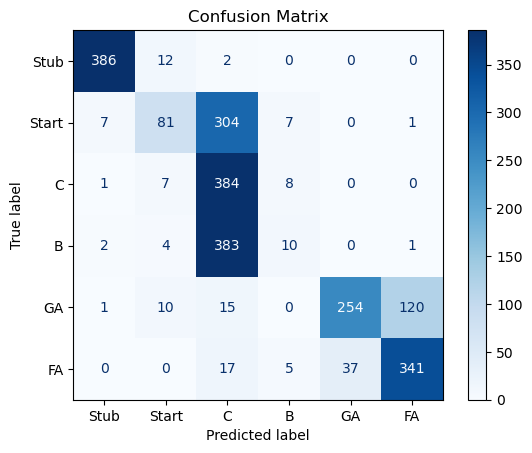

In [16]:
test_dataset = TensorDataset(X_test, torch.tensor(lengths_test), y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model
model.to("cuda")
model.eval()
# correct = 0
# total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, lengths_batch, y_batch in test_loader:
        X_batch, lengths_batch, y_batch = X_batch.to(device), lengths_batch.to(device), y_batch.to(device)
        outputs = model(X_batch, lengths_batch)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
        
#         total += y_batch.size(0)
#         correct += (predicted == y_batch).sum().item()
#     print(f'Accuracy: {100 * correct / total}%')

# Calculate accuracy
correct = sum([1 for true, pred in zip(all_labels, all_preds) if true == pred])
total = len(all_labels)
accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Stub', 'Start', 'C', 'B', 'GA', 'FA'])

# Plot confusion matrix
plt.figure(figsize=(12, 10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')

image_name = "LSTM Confusion Matrix"

plt.savefig(f"../Report/Image/{image_name}", dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [17]:
# # s0 = df['2_classes'][df['2_classes'] == "High"].sample(1051).index
# # s1 = df['2_classes'][df['2_classes'] == "Low"].sample(8000 - 1051).index
# # df = df.loc[s0.union(s1)]

# # df['text_embedding'] = df['text_embedding'].apply(string_to_numpy_array)

# def sample_group(group, n=2000):
#     return group.sample(n=min(len(group), n), random_state=1)

# # Apply the sampling function to each group
# df = df.groupby('rate').apply(sample_group).reset_index(drop=True)
# print(df['rate'].value_counts())

# print(df.dtypes['text_embedding'])  # Should be 'object'
# print(type(df['text_embedding'].iloc[0]))  # Should be <class 'numpy.ndarray'>
# print(df['text_embedding'].iloc[0].shape)
    
# numerical_features = df[['reference', 'external_link', 'internal_link', 'table', 'formula', 
#                          'images', 'section', 'subsection', 'subsubsection', 'paragraph', 'sentence',
#                          'flesch', 'flesch_kincaid', 'smog_index', 'coleman_liau', 'automated_readability', 
#                          'difficult_words', 'dale_chall', 'linsear', 'gunning_fog']]

# numerical_features = df[['external_link', 'internal_link', 'section', 'subsection', 'paragraph', 'sentence', 
#                          'flesch', 'coleman_liau', 'difficult_words', 'dale_chall']]

# # #     classes = {'High': 1, 'Low': 0}
# # #     df['2_classes'] = df['2_classes'].map(classes)
    
# classes = {'FA': 0, 'GA': 1, 'B': 2, 'C': 3, 'Start': 4, 'Stub': 5}
# df['rate'] = df['rate'].map(classes)
    
# # Normalize the numerical features
# scaler = MinMaxScaler()
# numerical_features_scaled = scaler.fit_transform(numerical_features)

# text_embeddings = [torch.tensor(embedding) for embedding in df['text_embedding']]
# lengths = [embedding.size(0) for embedding in text_embeddings]
# padded_embeddings = pad_sequence(text_embeddings, batch_first=True)  # Shape: (batch_size, max_seq_length, 768)
# print(f"Embedding Shape: {padded_embeddings.shape}")

# num_features = numerical_features_scaled.shape[1]
# numerical_features_tensor = torch.tensor(numerical_features_scaled, dtype=torch.float32)
# numerical_features_expanded = numerical_features_tensor.unsqueeze(1).expand(-1, padded_embeddings.size(1), -1)  # Shape: (batch_size, max_seq_length, num_features)
# print(f"Numerical Features Shape: {numerical_features_expanded.shape}")

# combined_input = torch.cat((padded_embeddings, numerical_features_expanded), dim=2)  # Shape: (batch_size, max_seq_length, 768 + num_features)
# print(f"Concate Shape: {combined_input.shape}")

# #     labels = torch.tensor(df['2_classes'].values)
# labels = torch.tensor(df['rate'].values)
    
# # Split the data into training and test sets
# X_train, X_test, y_train, y_test, lengths_train, lengths_test = train_test_split(combined_input, labels, lengths, test_size=0.2, stratify=labels, random_state=42)

# unique_values, counts = np.unique(y_train.numpy(), return_counts=True)

# display(unique_values)
# display(counts)

# # Convert data to PyTorch tensors and create DataLoader
# train_dataset = TensorDataset(X_train, torch.tensor(lengths_train), y_train)
# test_dataset = TensorDataset(X_test, torch.tensor(lengths_test), y_test)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
# # Define model parameters
# embedding_dim = 768
# num_features = numerical_features_scaled.shape[1]
# input_dim = embedding_dim + num_features
# hidden_dim = 512
# output_dim = 6
# num_layers = 3

# # Initialize the model, loss function, and optimizer
# model = ArticleClassifier(input_dim, hidden_dim, output_dim, num_layers)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training the model
# num_epochs = 50

# for epoch in range(num_epochs):
#     model.train()
#     for X_batch, lengths_batch, y_batch in train_loader:
#         X_batch, lengths_batch, y_batch = X_batch.to(device), lengths_batch.to(device), y_batch.to(device)

#         optimizer.zero_grad()
#         outputs = model(X_batch, lengths_batch)
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         optimizer.step()

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        
# # Evaluate the model
# model.eval()
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for X_batch, lengths_batch, y_batch in test_loader:
#         X_batch, lengths_batch, y_batch = X_batch.to(device), lengths_batch.to(device), y_batch.to(device)
#         outputs = model(X_batch, lengths_batch)
#         _, predicted = torch.max(outputs.data, 1)
#         total += y_batch.size(0)
#         correct += (predicted == y_batch).sum().item()

#     print(f'Accuracy: {100 * correct / total}%')

In [18]:
# Example of "numerical_features_tensor.unsqueeze(1).expand(-1, padded_embeddings.size(1), -1)"
# data = [[3, 2, 1], [6, 5, 4], [9, 8, 7]]
# tensor1 = torch.tensor(data)

# display(tensor1)
# display(tensor1.unsqueeze(1))
# display(tensor1.unsqueeze(1).expand(-1, 2, -1))